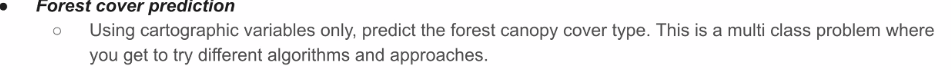

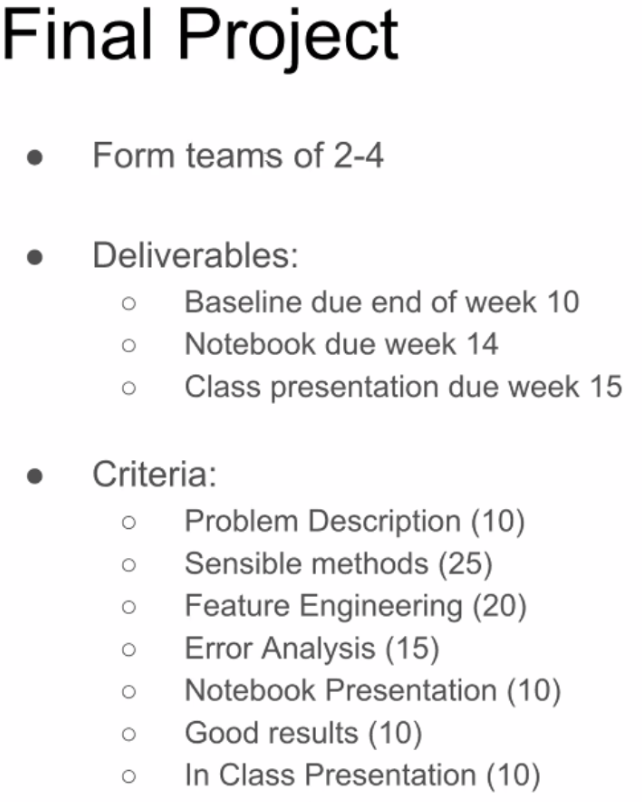

In [127]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import pandas as pd
pd.set_option('display.max_columns', None)

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [128]:
#Import Data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print('train_df size =', len(train_df))
print('test_df size =', len(test_df))
# print(train_df.columns)

train_df size = 15120
test_df size = 565892


#### Function to convert dataframe dataset into numpy train/dev data/label.

In [129]:
# Convert pd dataframe to np array
# Split train_df into training data and dev data

def data_to_np(train=train_df):
    '''Takes name of train_df name as argument in order to return data according to desired feature engineering. 
    Default is no feature engineering.'''
    forest_data = train.loc[:,train.columns != 'Cover_Type'].values
    forest_target = train[['Cover_Type']].values.flatten()
    X_train, X_dev, y_train, y_dev = train_test_split(forest_data, forest_target, test_size=0.3, random_state=0)
    return X_train, X_dev, y_train, y_dev

#### Feature Engineering Round 1 (Soil_Type15 , Id)
'Soil_Type15' is 'unspecified in the USFS Soil and ELU Survey.' This is not a distinct category and therefore does not aid classification. <br>
'Id' is not a feature, but rather acts to remove randomization, which is undesired.<br>

* Eliminate any row containing 'Soil_Type15'. Eliminate column for 'Soil_Type15'.
* Eliminate column for 'Id'



In [130]:
train_df1 = train_df[train_df['Soil_Type15'] == 0]
test_df1 = train_df[test_df['Soil_Type15'] == 0]

train_df1 = train_df.drop(columns = ['Id', 'Soil_Type15'])
test_df1 = test_df.drop(columns = ['Id', 'Soil_Type15'])

C:\Users\adamj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [131]:
#Random Forest Regressor for Feature Engineering Round1
X_train, X_dev, y_train, y_dev = data_to_np(train_df1)
names = train_df1.columns.values
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

C:\Users\adamj\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.4027, 'Elevation'), (0.0889, 'Horizontal_Distance_To_Roadways'), (0.0834, 'Horizontal_Distance_To_Fire_Points'), (0.0481, 'Horizontal_Distance_To_Hydrology'), (0.0412, 'Soil_Type39'), (0.0394, 'Vertical_Distance_To_Hydrology'), (0.0373, 'Hillshade_3pm'), (0.0327, 'Aspect'), (0.0303, 'Hillshade_Noon'), (0.03, 'Hillshade_9am'), (0.025, 'Slope'), (0.0249, 'Soil_Type38'), (0.0148, 'Soil_Type12'), (0.013, 'Wilderness_Area3'), (0.0108, 'Soil_Type32'), (0.01, 'Soil_Type35'), (0.0093, 'Wilderness_Area1'), (0.0068, 'Soil_Type10'), (0.0057, 'Soil_Type30'), (0.0045, 'Soil_Type40'), (0.0043, 'Soil_Type33'), (0.0041, 'Soil_Type13'), (0.004, 'Soil_Type29'), (0.0036, 'Soil_Type22'), (0.0025, 'Wilderness_Area4'), (0.0021, 'Soil_Type4'), (0.0021, 'Soil_Type23'), (0.002, 'Soil_Type24'), (0.0019, 'Soil_Type31'), (0.0017, 'Soil_Type11'), (0.0016, 'Soil_Type20'), (0.0013, 'Soil_Type6'), (0.0013, 'Soil_Type2'), (0.0013, 'Soil_Type17'), (0.0012, 'Wilderness_Area2'), (0.001

#### Feature Engineering Round 2 (Soil_Type to features, keep Soil_Type)
Description of Soil Types yields commonalities which expands a sample's feature set.

* Create single column in train_df & test_df for 'Soil_Type' to match soil_feature featurizer table.
* Merge train_df and test_df on soil_feature featurizer table 'Soil_Type' column
* Eliminate Soil_Type columns. 
* Inclusive of Round1


In [132]:
#Import data of featurizer table
soil_feature = pd.read_csv('soil_feature.csv')

#Establish dataframes as deep copies
train_df2 = train_df1.copy(deep= True)
test_df2 = test_df1.copy(deep= True)

#Aggregating soil types in train_df2 and test_df2 for use as merge index
soil_cols = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40']
train_df2['Soil_Type'] = train_df2[soil_cols].idxmax(axis=1)
test_df2['Soil_Type'] = test_df2[soil_cols].idxmax(axis=1)

#Merging train_df2 and test_df2 with soil_feature
train_df2 = train_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')
test_df2 = test_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')

#Manually reordering columns on train_df2 to make 'Cover_Type' at the end of the list.  
#Note this is not necessary for test2_df due to absence of 'Cover_Type' column. 
#Also eliminating 'Soil_Type' columns.
reordered_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Rock outcrop', 'Rock Land',
#        'Complex',
        'Stony', 'Rubbly', 'Cyraquolls', 'Cryumbrepts',
       'Cryorthents', 'Leighcan', 'Till substratum', 'Catmount', 'Legault',
       'Moran', 'Bullwark', 'Crayaquepts', 'Vanet', 'Como', 'Cover_Type']
train_df2 = train_df2[reordered_cols]

In [133]:
#Random Forest Regressor for Feature Engineering Round2
X_train, X_dev, y_train, y_dev = data_to_np(train_df2)
names = train_df2.columns.values
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

C:\Users\adamj\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.3048, 'Elevation'), (0.1798, 'Moran'), (0.0962, 'Horizontal_Distance_To_Roadways'), (0.0951, 'Horizontal_Distance_To_Fire_Points'), (0.0513, 'Horizontal_Distance_To_Hydrology'), (0.0367, 'Hillshade_3pm'), (0.0359, 'Hillshade_9am'), (0.0342, 'Vertical_Distance_To_Hydrology'), (0.0329, 'Aspect'), (0.0314, 'Hillshade_Noon'), (0.0214, 'Slope'), (0.0151, 'Wilderness_Area1'), (0.0088, 'Bullwark'), (0.0083, 'Wilderness_Area3'), (0.0078, 'Cryumbrepts'), (0.0075, 'Rubbly'), (0.0066, 'Rock Land'), (0.0041, 'Leighcan'), (0.0038, 'Como'), (0.0025, 'Rock outcrop'), (0.0024, 'Legault'), (0.0023, 'Catmount'), (0.0021, 'Cyraquolls'), (0.0019, 'Wilderness_Area2'), (0.0019, 'Vanet'), (0.0016, 'Wilderness_Area4'), (0.0015, 'Stony'), (0.0008, 'Till substratum'), (0.0007, 'Crayaquepts'), (0.0005, 'Cryorthents')]


#### Feature Engineering Round 3 (Feature Reduction)
Reducing features to only those w/ random forest scoring > 0.1
* Inclusive of Round2

In [134]:
#Establish dataframes as deep copies
train_df3 = train_df2.copy(deep= True)
test_df3 = test_df2.copy(deep= True)

train_df3 = train_df3.reset_index(drop=True)

print(train_df3.columns)
print(train_df3['Cover_Type'].head(9))

train_keys = ['Elevation', 'Moran', 'Horizontal_Distance_To_Roadways', 'Cover_Type']
test_keys = ['Elevation', 'Moran', 'Horizontal_Distance_To_Roadways']

train_df3 = train_df3[train_keys]
test_df3 = test_df3[test_keys]

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Rock outcrop', 'Rock Land', 'Stony', 'Rubbly', 'Cyraquolls',
       'Cryumbrepts', 'Cryorthents', 'Leighcan', 'Till substratum', 'Catmount',
       'Legault', 'Moran', 'Bullwark', 'Crayaquepts', 'Vanet', 'Como',
       'Cover_Type'],
      dtype='object')
0    5
1    5
2    2
3    2
4    5
5    2
6    5
7    5
8    5
Name: Cover_Type, dtype: int64


#### Function to score KNeighborsClassifier and GaussianNB results

In [135]:
def score_fn(classifier, feat_eng = train_df1):
    '''Takes classifier function and feature engineering level as argument and returns score.'''
    data_train, data_dev, label_train, label_dev = data_to_np(feat_eng)
    cls = classifier
    cls.fit(data_train, label_train)
    cls_pred = cls.predict(data_dev)

    return cls.score(data_dev, label_dev)

#### Simple implementation of KNeighborsClassifier and GaussianNB using default hyperparameters.  Feature Enginering Level1 

In [136]:
#Default knn parameters: (n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]
print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df1),4))
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df1),4))

knn_score: 0.7822
gnb_score: 0.5933


#### Simple implementation of KNeighborsClassifier and GaussianNB using default hyperparameters. Feature Enginering Level2

In [137]:
#Default knn parameters: (n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]
print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df2),4))
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df2),4))

knn_score: 0.7822
gnb_score: 0.5851


#### Simple implementation of KNeighborsClassifier and GaussianNB using default hyperparameters. Feature Enginering Level3

In [138]:
#Default knn parameters: (n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]
print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df3),4))
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df3),4))

knn_score: 0.5813
gnb_score: 0.5375


https://stats.stackexchange.com/questions/169400/naive-bayes-questions-continus-data-negative-data-and-multinomialnb-in-scikit
Why can't negative data be used here?
MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values.

How is scikit-learn handling the continuous data?
If you want to work with bayesian methods use GaussianNb but generally there are a lot of estimators capable of handling continuous data in scikit-learn.